# CNN을 이용한 폐렴 예측

## 0. 라이브러리

In [ ]:
import os, time, random

import numpy as np
import pandas as pd
import cv2 # OpenCV

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

# import warnings
# warnings.filterwarnings('ignore')

## 1. 데이터

* https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
* 5,863개의 흉부 X선 영상(JPEG)
    * Dataset: Train(학습) | Test(검증) | Val(평가)
    * Label: Pneumonia(0, 폐렴) | Normal(1, 정상)
* 흉부 X선 영상(앞-뒤)은 광저우 여성 및 어린이 의료 센터의 1~5세 소아 환자의 회고적 코호트에서 선택되었습니다. 모든 흉부 X선 촬영은 환자의 일상적인 임상 치료의 일환으로 수행되었습니다.
* 흉부 X선 영상 분석을 위해 모든 흉부 방사선 사진은 처음에 저품질 또는 판독 불가능한 스캔을 모두 제거하여 품질 관리를 위해 선별되었으며, 이미지에 대한 진단은 AI 시스템 훈련을 위해 승인되기 전에 두 명의 전문 의사에 의해 등급이 매겨졌습니다. 채점 오류를 설명하기 위해, 평가 세트는 또한 세 번째 전문가에 의해 확인되었습니다.

### 1) 다운로드/로드

In [4]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

# print('Path to dataset files:', path)

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    images = []
    class_labels = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        if not os.path.exists(path): # 폴더 존재 여부 확인
            print(f'Warning: Directory {path} does not exist. Skipping.')
            continue

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_arr is None: # 이미지 로드 여부 확인
                    print(f'Warning: Unable to read {img_path}. Skipping.')
                    continue

                resized_img_arr = cv2.resize(img_arr, (img_size, img_size))  # 이미지 크기 조정
                images.append(resized_img_arr)
                class_labels.append(class_num)

            except Exception as e:
                print(f'Error processing {img}: {e}')
    
    return np.array(images, dtype=np.float32), np.array(class_labels, dtype=np.int64)


In [6]:
dataset_dir = './dataset/chest_xray'

x_train, y_train = get_data(dataset_dir+'/train')
x_val, y_val = get_data(dataset_dir+'/test')
x_test, y_test = get_data(dataset_dir+'/val')

In [7]:
# 데이터 개수
print('Train Dataset Shape:', x_train.shape, y_train.shape)
print('Validate Dataset Shape:', x_val.shape, y_val.shape)
print('Test Dataset Shape:', x_test.shape, y_test.shape)

Train Dataset Shape: (5216, 150, 150) (5216,)
Validate Dataset Shape: (624, 150, 150) (624,)
Test Dataset Shape: (16, 150, 150) (16,)


### 2) 탐색

1. 분포 확인 -> 데이터 불균형 (정상 이미지가 상대적으로 너무 적음)
2. 샘플 이미지 확인

In [8]:
# 분포 확인
pneumonia_cnt = 0
normal_cnt = 0

for y in y_train:
    if y==0:
        pneumonia_cnt += 1
    else:
        normal_cnt += 1

print('Pneumonia 개수:', pneumonia_cnt)
print('Normal 개수:', normal_cnt)

Pneumonia 개수: 3875
Normal 개수: 1341


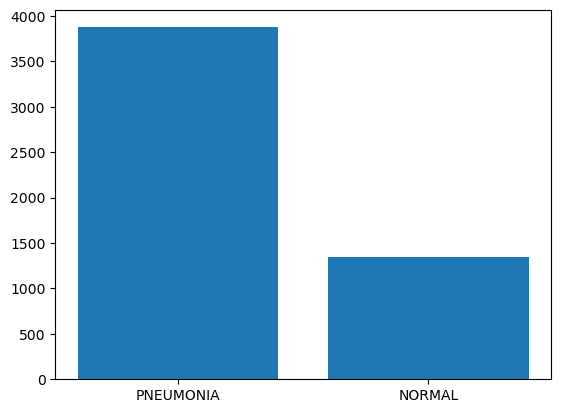

In [9]:
x = np.arange(2)
cnt_list = [pneumonia_cnt, normal_cnt]
label = ['PNEUMONIA', 'NORMAL']

plt.bar(x, cnt_list)
plt.xticks(x, label)

plt.show()

Text(0.5, 1.0, 'NORMAL')

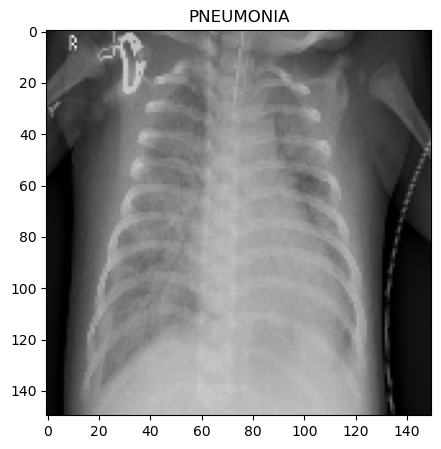

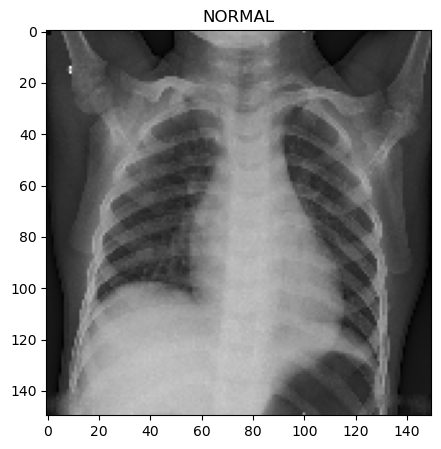

In [10]:
# 샘플 이미지 확인
plt.figure(figsize=(5,5))
plt.imshow(x_train[0], cmap='gray') # pneumonia
plt.title(labels[y_train[1]])

plt.figure(figsize=(5,5))
plt.imshow(x_train[-1], cmap='gray') # normal
plt.title(labels[y_train[-1]])

### 3) 전처리

1. 그레이스케일 정규화(Greyscale Normalization)
    * 이미지별 조도(빛의 양)의 차이를 줄이고 CNN 모델의 수렴 속도를 증가
    * 정규화를 마친 데이터는 0~1 사이의 값을 가짐

2. 크기 변환
    * CNN 모델의 학습을 위해 1차원 추가 -> 채널 차원 추가 (index=1)

3. 데이터 증강(Data Augmentation)
    * 데이터 증강: 과적합 문제를 피하기 위해 데이터 세트를 인위적으로 확장하는 기술
    * 라벨을 동일하게 유지하면서 array 표현을 변경하는 방식으로 학습 데이터 증강 가능
        * 학습 데이터에 적용하면 학습 데이터의 수를 쉽게 늘려 보다 강력한 모델을 만들 수 있음
    * 이미지 데이터의 증강 기법: 그레이스케일, 수평 플립, 수직 플립, 무작위 크롭, 컬러 변화, 이동, 회전 등
        * RandomRotation(): 랜덤 방향으로 회전 (-N ~ N)
        * RandomResizedCrop(): 랜덤으로 잘라냄
        * RandomAffine(): 랜덤 방향으로 이동
        * RandomHorizontalFlip(): 랜점으로 좌우 반전

#### 그레이스케일 정규화

In [11]:
x_train /= 255
x_val /= 255
x_test /= 255

In [12]:
print(x_train[0].shape)
x_train[0]

(150, 150)


array([[0.07058824, 0.10980392, 0.11372549, ..., 0.05098039, 0.02745098,
        0.00392157],
       [0.08235294, 0.09411765, 0.11372549, ..., 0.05490196, 0.03529412,
        0.01176471],
       [0.08627451, 0.10196079, 0.1254902 , ..., 0.0627451 , 0.03529412,
        0.00784314],
       ...,
       [0.03921569, 0.03529412, 0.03137255, ..., 0.05882353, 0.05882353,
        0.05882353],
       [0.03921569, 0.03921569, 0.03137255, ..., 0.05882353, 0.05882353,
        0.05882353],
       [0.03921569, 0.03921569, 0.03137255, ..., 0.05882353, 0.05882353,
        0.05882353]], dtype=float32)

#### 크기 변환

In [13]:
print('x_train shape:', x_train.shape) # (데이터 개수, 가로, 세로)

x_train shape: (5216, 150, 150)


In [14]:
x_train = x_train.reshape(-1, 1, img_size, img_size)
x_val = x_val.reshape(-1, 1, img_size, img_size)
x_test = x_test.reshape(-1, 1, img_size, img_size)

print('reshaped x_train shape:', x_train.shape) # (데이터 개수, 채널, 가로, 세로)

reshaped x_train shape: (5216, 1, 150, 150)


#### 데이터 증강

In [15]:
print('학습 데이터 총 개수:', len(x_train))
print('학습 데이터 중 폐렴 개수:', len(x_train[y_train==0]))
print('학습 데이터 중 정상 개수:', len(x_train[y_train==1]))

print('\n학습 데이터의 라벨 개수 차이:', len(x_train[y_train==0])-len(x_train[y_train==1]))

학습 데이터 총 개수: 5216
학습 데이터 중 폐렴 개수: 3875
학습 데이터 중 정상 개수: 1341

학습 데이터의 라벨 개수 차이: 2534


In [16]:
# 랜덤 방향으로 최대 30도 회전 (-30~30 사이로 랜덤하게 회전)
rotate = transforms.RandomRotation(30, fill=0)

# 랜덤으로 잘라냄 (scale=(min %, max %), ratio=[가로 비율, 세로 비율])
zoom = transforms.RandomResizedCrop(150, scale=(0.8, 1.0), ratio=[1.0, 1.0])

# 랜덤 방향(상화좌우)으로 이동 (degrees, translate=[좌우 비율, 수직 비율])
hshift = transforms.RandomAffine(0, translate=[0.1, 0]) # 좌우로 10% 이동
vshift = transforms.RandomAffine(0, translate=[0, 0.1]) # 상하로 10% 이동

# 좌우 반전 (p=발생 확률 %)
hflip = transforms.RandomHorizontalFlip(p=0.5)

In [17]:
# 전처리 일괄 처리
transform_list = [rotate, zoom, hshift, vshift, hflip]

transform_pipe = transforms.Compose(
    transform_list
)

In [18]:
def show_img(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2 ,0))) # index 변경
    plt.show()

Original Images


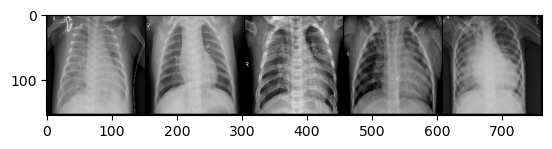


Transformed Images


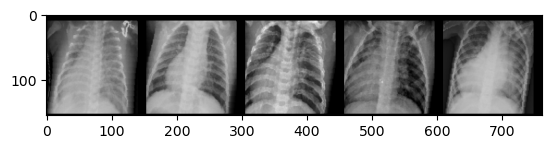

In [19]:
make_grid = torchvision.utils.make_grid # 격자 시각화

original_imgs = torch.Tensor(x_train[:5]) # 원본 샘플 데이터
transformed_imgs = transform_pipe(original_imgs) # 전처리된 샘플 데이터

print('Original Images')
show_img(make_grid(original_imgs))

print('\nTransformed Images')
show_img(make_grid(transformed_imgs))

In [20]:
# 학습 데이터 중 정상 데이터만 증식
targets = x_train[y_train==1]
labels = y_train[y_train==1]

difference = len(x_train[y_train==0]) - len(x_train[y_train==1])
num_aug = int(difference/3)

In [21]:
# select_one이 True이면 하나의 변환만 랜덤 적용
select_one = True

aug_images = []
aug_labels = []

for _ in range(num_aug):
    index = random.randint(0, len(targets)-1)
    sample = torch.Tensor(targets[index])

    if select_one: # 샘플당 하나의 증강 기법만 무작위로 적용
        aug_index = random.randint(0, len(transform_list) - 1)
        transform_pipe = transform_list[aug_index]

    transformed_sample = transform_pipe(sample).numpy()  # 증강 적용 후 numpy 변환
    aug_images.append(transformed_sample)  # 변환된 데이터 추가
    aug_labels.append(labels[index])  # 라벨 추가

# list -> nparray
aug_images = np.array(aug_images, dtype=np.float32)
aug_labels = np.array(aug_labels, dtype=np.int64)

In [22]:
print('증강 데이터 shape:', aug_images.shape, '/', aug_labels.shape)

증강 데이터 shape: (844, 1, 150, 150) / (844,)


Transformed images


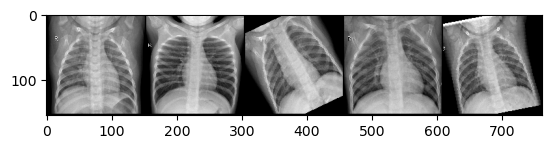

In [23]:
# 증강 데이터 확인
aug_imgs = torch.Tensor(aug_images[:5])

print('Transformed images')
show_img(make_grid(aug_imgs))

In [24]:
# 증강 데이터 추가
x_train_augged = np.concatenate((x_train, aug_images), axis=0)
y_train_augged = np.concatenate((y_train, aug_labels), axis=0)

In [25]:
print('최종 학습 데이터 shape:', x_train_augged.shape, '/', y_train_augged.shape)

최종 학습 데이터 shape: (6060, 1, 150, 150) / (6060,)


In [26]:
print('학습 데이터 총 개수:', len(x_train_augged))
print('학습 데이터 중 폐렴 개수:', len(x_train_augged[y_train_augged==0]))
print('학습 데이터 중 정상 개수:', len(x_train_augged[y_train_augged==1]))

print('\n학습 데이터의 라벨 개수 차이:', len(x_train_augged[y_train_augged==0])-len(x_train_augged[y_train_augged==1]))

학습 데이터 총 개수: 6060
학습 데이터 중 폐렴 개수: 3875
학습 데이터 중 정상 개수: 2185

학습 데이터의 라벨 개수 차이: 1690


## 2. 모델링

### 1) 데이터셋 로드


1. 데이터의 자료형을 torch.Tensor로 변환
    * pytorch 모델은 torch.Tensor 계열의 자료형을 입출력으로 사용
2. DataLoader로 변환
    * 배치 단위로 묶기

#### Tensor 변환

In [27]:
class CustomImageDataset(Dataset):
    
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return (torch.Tensor(image), torch.Tensor([label]))

In [28]:
train_set = CustomImageDataset(x_train_augged, y_train_augged)
val_set = CustomImageDataset(x_val, y_val)
test_set = CustomImageDataset(x_test, y_test)

In [29]:
len(train_set), len(val_set), len(test_set)

(6060, 624, 16)

In [30]:
# 원래 데이터
(x_train_augged[0], y_train_augged[0])

(array([[[0.07058824, 0.10980392, 0.11372549, ..., 0.05098039,
          0.02745098, 0.00392157],
         [0.08235294, 0.09411765, 0.11372549, ..., 0.05490196,
          0.03529412, 0.01176471],
         [0.08627451, 0.10196079, 0.1254902 , ..., 0.0627451 ,
          0.03529412, 0.00784314],
         ...,
         [0.03921569, 0.03529412, 0.03137255, ..., 0.05882353,
          0.05882353, 0.05882353],
         [0.03921569, 0.03921569, 0.03137255, ..., 0.05882353,
          0.05882353, 0.05882353],
         [0.03921569, 0.03921569, 0.03137255, ..., 0.05882353,
          0.05882353, 0.05882353]]], dtype=float32),
 np.int64(0))

In [31]:
# tensor 변환 데이터
train_set.__getitem__(0)

(tensor([[[0.0706, 0.1098, 0.1137,  ..., 0.0510, 0.0275, 0.0039],
          [0.0824, 0.0941, 0.1137,  ..., 0.0549, 0.0353, 0.0118],
          [0.0863, 0.1020, 0.1255,  ..., 0.0627, 0.0353, 0.0078],
          ...,
          [0.0392, 0.0353, 0.0314,  ..., 0.0588, 0.0588, 0.0588],
          [0.0392, 0.0392, 0.0314,  ..., 0.0588, 0.0588, 0.0588],
          [0.0392, 0.0392, 0.0314,  ..., 0.0588, 0.0588, 0.0588]]]),
 tensor([0.]))

#### DataLoader 변환

In [32]:
batch_size = 32
num_workers = 0

In [33]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [34]:
len(train_loader), len(val_loader), len(test_loader)

(190, 20, 1)

In [35]:
print(next(iter(train_loader))[0].shape) # x [batch_size, 1, img_size, img_size]
print(next(iter(train_loader))[1].shape) # y [batch_size, 1]

torch.Size([32, 1, 150, 150])
torch.Size([32, 1])


(3, 610, 1218)


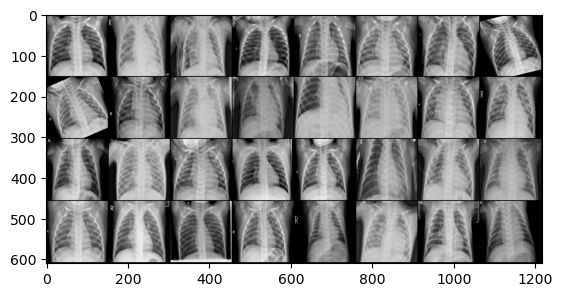

In [ ]:
# 미니 배치 이미지 출력
def show_batch_img(img):
    np_img = img.numpy()
    print(np_img.shape)

    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
next(dataiter)
images, labels = next(dataiter) # 두 번째 미니 배치 시각화

show_batch_img(torchvision.utils.make_grid(images))

### 2) 모델 설계

* CNN 기반의 BinaryClassifier
    * Convolutaional 레이어를 거치며 재구축된 image의 representation을 통해 Fully Connected 레이어에서 분류 작업을 수행하는 모델
    * 4층의 Convolutaional 레이어 + 2층의 Fully Connected 레이어
    * 출력값은 sigmoid 함수를 거쳐 0과 1 사이로 반환

    * Batch Normalization (배치 정규화) 적용
        * CNN을 이용할 때, 데이터를 정규화
        * 미니 배치 별로 따로 정규화 -> 왜 굳이 따로? 모든 데이터를 한 번에 GPU 메모리에 올리는 것이 불가능하기 때문에~

    * Dropout 적용
        * 학습할 때, 랜덤으로 weight를 잠깐 꺼버림 -> weight의 민감도를 떨굼 -> overfitting 방지
    * 구조
        * 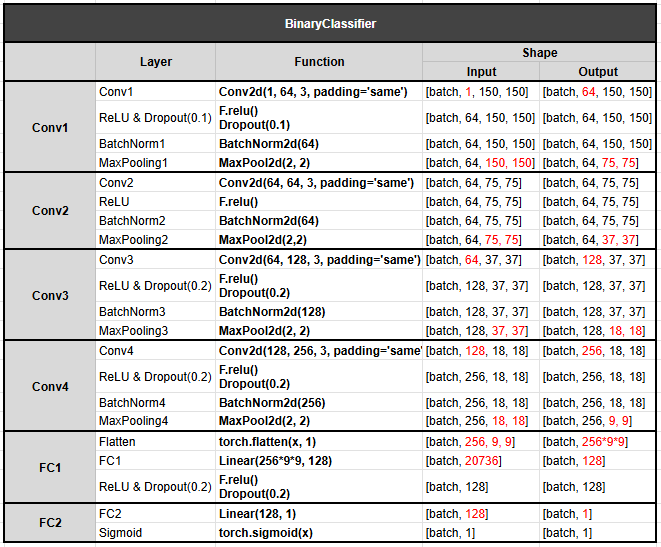

* Scheduler
    * learning_rate는 상수 -> 학습 초반에는 클수록 좋지만, 후반으로 갈수록 작으면 좋음
    * 특정 step 이후로 loss 값이 줄어들지 않는다면, learning_rate를 줄여주는 역할

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, stride=1, padding='same')
        self.conv1_bn = nn.BatchNorm2d(64) # 64 -> conv1의 out channel

        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding='same')
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding='same')
        self.conv3_bn = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding='same')
        self.conv4_bn = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(256*9*9, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(self.conv1_bn(self.dropout1(F.relu(self.conv1(x))))) # conv1 > relu > dropout1 > batch_normalize > pool
        x = self.pool(self.conv2_bn(F.relu(self.conv2(x))))                # conv2 > relu > batch_normalize > pool
        x = self.pool(self.conv3_bn(self.dropout2(F.relu(self.conv3(x))))) # conv3 > relu > dropout2 > batch_normalize > pool
        x = self.pool(self.conv4_bn(self.dropout2(F.relu(self.conv4(x))))) # conv4 > relu > dropout2 > batch_normalize > pool
        x = torch.flatten(x, 1)
        x = F.relu(self.dropout2(self.fc1(x))) # fc1 > dropout2 < relu
        x = torch.sigmoid(self.fc2(x))         # fc2 > sigmoid
        return x

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [54]:
model = BinaryClassifier().to(device)

In [55]:
learning_rate = 5e-05

criterion = nn.BCELoss(reduction='sum') # 손실 함수
optimizer = Adam(model.parameters(), lr=learning_rate) # 최적화 알고리즘
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.3, min_lr=1e-6)

### 3) 모델 학습

In [49]:
# 학습
def train(model, optimizer, criterion, train_loader):
    model.train()

    total_loss = 0
    corrects = 0
    total_samples = 0

    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device).float().squeeze() # squeeze -> 1인 차원 축소 (혹시나 2D라면 1D로 변환)

        logit = model(x).squeeze()
        loss = criterion(logit, y)

        total_loss += loss.item()

        # 아래 3줄의 코드의 순서 주의!! (zero_grad -> backward -> step)
        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 역전파 -> loss에 대한 모든 가중치의 기울기 계산
        optimizer.step() # 가중치 업데이트

        prediction = torch.round(logit)
        corrects += (prediction==y).sum().item()

        total_samples += x.shape[0]
    
    avg_loss = total_loss/total_samples
    avg_accuracy = 100.0*corrects/total_samples

    return avg_loss, avg_accuracy

In [50]:
# 검증
def evaluate(model, criterion, val_loader):
    model.eval()

    total_loss = 0
    corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.to(device).float().squeeze()

            logit = model(x).squeeze()
            loss = criterion(logit, y)

            total_loss += loss.item()

            prediction = torch.round(logit)
            corrects += (prediction==y).sum().item()

            total_samples += x.shape[0]
    
    avg_loss = total_loss/total_samples
    avg_accuracy = 100.0*corrects/total_samples
    
    return avg_loss, avg_accuracy

In [45]:
# 실행 시간 계산
def epoch_time(start_time, end_time):
    elapsed_time = end_time-start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time-(elapsed_mins*60))
    return elapsed_mins, elapsed_secs

In [56]:
num_epoch = 20
best_val_loss = None

In [57]:
for epoch in range(num_epoch):

    start_time = time.time()

    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, val_loader)

    scheduler.step(val_loss)
    cur_lr = scheduler.optimizer.state_dict()['param_groups'][0]['lr']

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'Learning Rate: {cur_lr}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_accuracy:.2f}%')

    if best_val_loss is None or val_loss<best_val_loss: # val_loss 값이 가장 적게 나왔을 때의 모델을 저장
        torch.save(model.state_dict(), './models/BC_best.pt')
        best_val_loss = val_loss

Epoch: 01 | Epoch Time: 0m 7s
Learning Rate: 5e-05
	Train Loss: 0.141 | Train Acc: 93.91%
	 Val. Loss: 0.822 |  Val. Acc: 70.83%
Epoch: 02 | Epoch Time: 0m 7s
Learning Rate: 5e-05
	Train Loss: 0.061 | Train Acc: 97.62%
	 Val. Loss: 0.775 |  Val. Acc: 74.36%
Epoch: 03 | Epoch Time: 0m 7s
Learning Rate: 5e-05
	Train Loss: 0.041 | Train Acc: 98.47%
	 Val. Loss: 0.739 |  Val. Acc: 75.64%
Epoch: 04 | Epoch Time: 0m 7s
Learning Rate: 5e-05
	Train Loss: 0.023 | Train Acc: 99.31%
	 Val. Loss: 0.689 |  Val. Acc: 78.69%
Epoch: 05 | Epoch Time: 0m 7s
Learning Rate: 5e-05
	Train Loss: 0.017 | Train Acc: 99.50%
	 Val. Loss: 0.750 |  Val. Acc: 78.53%
Epoch: 06 | Epoch Time: 0m 7s
Learning Rate: 5e-05
	Train Loss: 0.009 | Train Acc: 99.67%
	 Val. Loss: 1.067 |  Val. Acc: 74.68%
Epoch: 07 | Epoch Time: 0m 7s
Learning Rate: 1.5e-05
	Train Loss: 0.008 | Train Acc: 99.70%
	 Val. Loss: 0.718 |  Val. Acc: 79.81%
Epoch: 08 | Epoch Time: 0m 7s
Learning Rate: 1.5e-05
	Train Loss: 0.003 | Train Acc: 99.95%
	 V

### 4) 모델 저장 및 로드

In [58]:
# 가장 마지막 상태의 모델 저장
LAST_MODEL_SAVE_PATH = './models/BC_last.pt'
torch.save(model.state_dict(), LAST_MODEL_SAVE_PATH)

In [59]:
BEST_MODEL_SAVE_PATH = './models/BC_best.pt'

model = BinaryClassifier().to(device) # 기본 모델 생성
model.load_state_dict(torch.load(BEST_MODEL_SAVE_PATH)) # 상태 덮어쓰기

<All keys matched successfully>

### 5) 성능 평가

In [60]:
test_loss, test_accuracy = evaluate(model, criterion, test_loader)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_accuracy:.2f}%')

Test Loss: 0.096 |  Test Acc: 100.00%


#### 혼돈 행렬(Confusion Matrix)

* validation dataset

In [71]:
predictions = []
labels = []

with torch.no_grad():
    for batch in val_loader:
        x, y = batch
        x, y = x.to(device), y.to(device).float().squeeze()

        logit = model(x).squeeze()

        prediction = torch.round(logit)
        predictions.append(prediction)

        labels.append(y)

predictions = torch.cat(predictions).cpu().numpy() # cat=concat
labels = torch.cat(labels).cpu().numpy()

In [84]:
predictions = np.array(predictions).astype(int)
labels = np.array(labels).astype(int)

class_labels = ['PNEUMONIA', 'NORMAL']

cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

print(cm)
cm_df

[[385   5]
 [128 106]]


,PNEUMONIA,NORMAL
PNEUMONIA,385,5
NORMAL,128,106


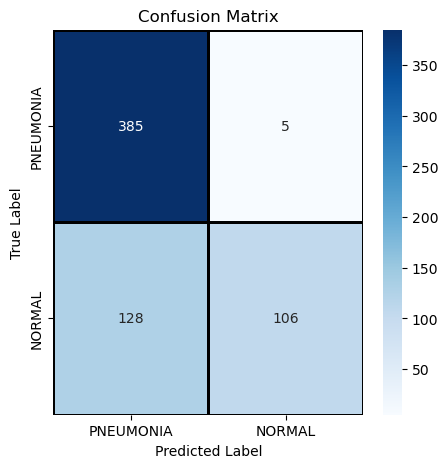

In [85]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm_df, cmap='Blues', linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [86]:
correct_index = np.nonzero(predictions==labels)[0]
incorrect_index = np.nonzero(predictions!=labels)[0]

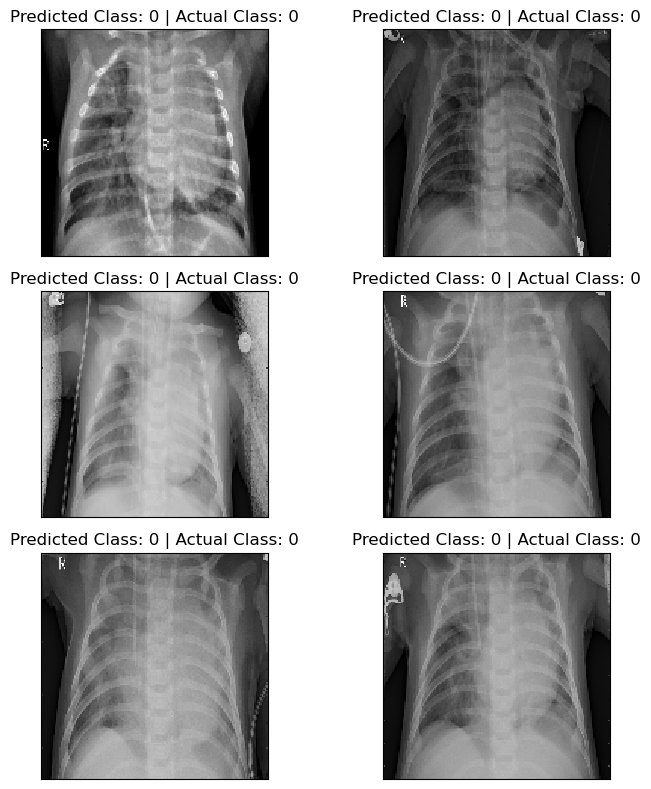

In [88]:
# 모델이 맞힌 데이터
plt.figure(figsize=(8, 8))

for i, index in enumerate(correct_index[:6]):
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_val[index].squeeze(), cmap='gray', interpolation='none')
    plt.title('Predicted Class: {} | Actual Class: {}'.format(predictions[index], y_val[index]))

plt.tight_layout()
plt.show()    

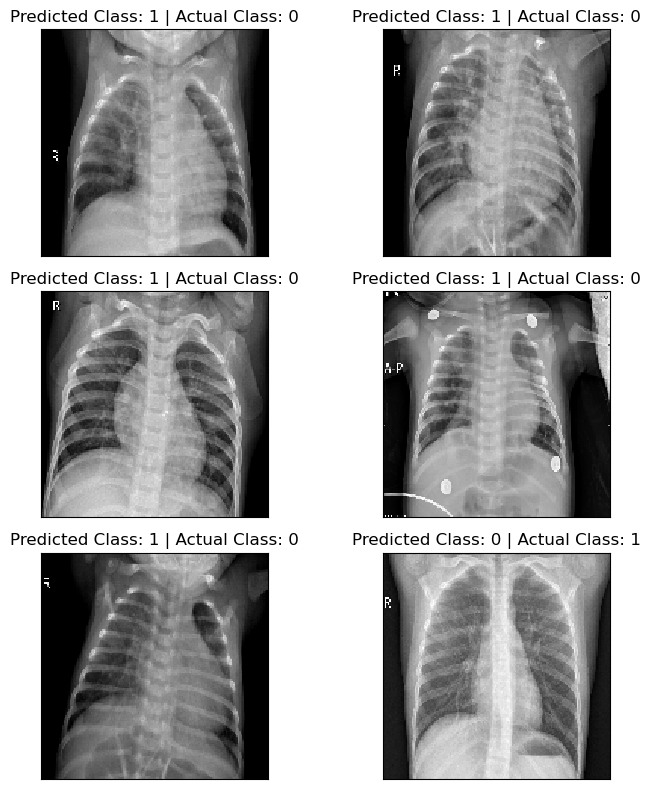

In [89]:
# 모델이 틀린 데이터
plt.figure(figsize=(8, 8))

for i, index in enumerate(incorrect_index[:6]):
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_val[index].squeeze(), cmap='gray', interpolation='none')
    plt.title('Predicted Class: {} | Actual Class: {}'.format(predictions[index], y_val[index]))

plt.tight_layout()
plt.show()    